In [1]:
import torch
import gpytorch
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from BO import BayesianOptimizer

In [2]:
# Maps
n_dims = 2

# Hyperparameters
noise_min = 0.001
noise_max = 5
rho_high = 8.0
rho_low = 0.001
std_min = 10
std_max = 200
kappa = 4

priorbox = gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low), b=math.log(rho_high))
priorbox2 = gpytorch.priors.SmoothedBoxPrior(
    a=math.log(std_min**2), b=math.log(std_max**2)
)

matk = gpytorch.kernels.MaternKernel(
    nu=2.5, ard_num_dims=n_dims, lengthscale_prior=priorbox
)
matk_scaled = gpytorch.kernels.ScaleKernel(matk, outputscale_prior=priorbox2)
matk_scaled.base_kernel.lengthscale = [1.0] * n_dims
matk_scaled.outputscale = [1.0]


prior_lik = gpytorch.priors.SmoothedBoxPrior(a=noise_min**2, b=noise_max**2)
likf = gpytorch.likelihoods.GaussianLikelihood()  # noise_prior=prior_lik)
likf.noise = [1.0]

Cebus 1:

In [3]:
data = loadmat("datasets/neurostim/Cebus1_M1_190221.mat")["Cebus1_M1_190221"]
emgs = np.squeeze(data["emgs"][0][0], axis=0)
ch2xy = data["ch2xy"][0][0] - 1

sorted_resp = data["sorted_resp"][0, 0].T
sorted_isvalid = data["sorted_isvalid"][0, 0].T
valid = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))
response = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))

for emg in range(emgs.shape[0]):
    for chan in range(sorted_resp.shape[1]):
        response[:, emg, chan] = np.squeeze(sorted_resp[emg, chan], axis=1)
        valid[:, emg, chan] = np.squeeze(sorted_isvalid[emg, chan], axis=1)


valid_respMean = np.zeros((response.shape[2], emgs.shape[0]))


for chan in range(response.shape[2]):
    for emg in range(emgs.shape[0]):
        valid_idx = list(np.where(valid[:, emg, chan] == 1)[0])
        non_valid_non_detectable_idx = list(np.where(valid[:, emg, chan] == -1)[0])
        all_valid_idx = valid_idx + non_valid_non_detectable_idx
        valid_respMean[chan, emg] = np.mean(response[all_valid_idx, emg, chan])


ch2xy = torch.from_numpy(ch2xy).float()
response = torch.from_numpy(response).float()
valid_respMean = torch.from_numpy(valid_respMean).float().permute(1, 0)
valid = torch.from_numpy(valid).float()

print(ch2xy.shape)
print(response.shape)
print(valid_respMean.shape)
print(valid.shape)

torch.Size([96, 2])
torch.Size([28, 6, 96])
torch.Size([6, 96])
torch.Size([28, 6, 96])


Display Ground Truth:

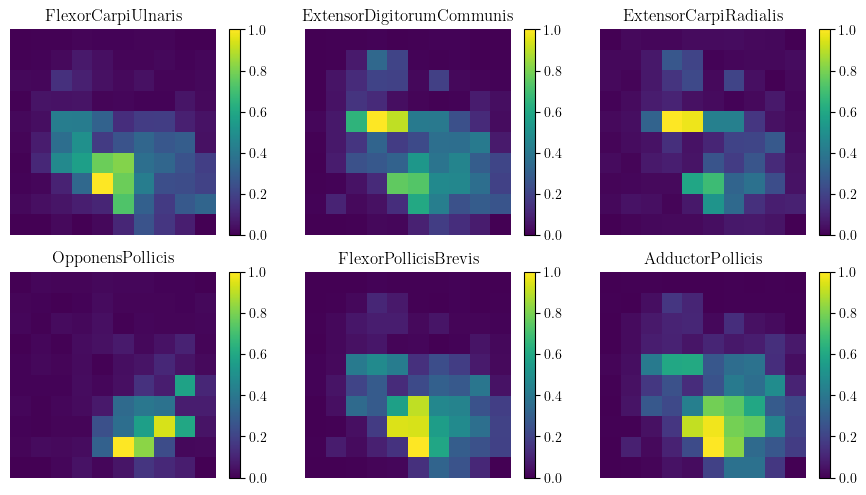

In [4]:
im = np.zeros((10, 10))

n_cols, n_rows = 2, 3

import matplotlib

font = {"weight": "normal", "size": 12}
matplotlib.rc("font", **{"family": "serif", "serif": ["Times New Roman"]})
matplotlib.rc("text", usetex=True)
fig, axs = plt.subplots(n_cols, n_rows, figsize=(9, 5))
# Remplissage de chaque carte avec les valeurs de response correspondantes
for i, ax in enumerate(axs.flat):
    im.fill(0)  # Remise à zéro de la carte pour chaque sous-plot
    valid_respMean[i] = (valid_respMean[i] - valid_respMean[i].min()) / (
        valid_respMean[i].max() - valid_respMean[i].min()
    )
    for j in range(len(ch2xy)):
        x, y = ch2xy[j]
        im[int(x), int(y)] = valid_respMean[i, j]

    image = ax.imshow(im, cmap="viridis", interpolation="nearest")
    ax.set_title("{}".format(emgs[i][0]))
    cbar = fig.colorbar(image, ax=ax)
    ax.axis("off")


plt.tight_layout()
# plt.show()

plt.savefig("cebus1.pdf", bbox_inches="tight")

In [5]:
mean_regret_cebus1 = np.zeros((response.shape[1], 150, 3))
q_star = 35


for emg in range(response.shape[1]):
    print("emg ", emg)
    response_emg = response[:, emg, :]
    isvalid_emg = valid[:, emg, :]
    respMean_emg = valid_respMean[emg, :]

    opt = BayesianOptimizer(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )

    regret_gpbo, baseline = opt.train(
        4,
        initial_points=1,
        repetitions=30,
        iterations=150,
        strategy="Vanilla BO",
    )
    regret_mpbo, _ = opt.train(
        4,
        repetitions=30,
        iterations=150,
        strategy="MP-BO",
        begin_strat=q_star,
        initial_points=q_star,
        follow_baseline=baseline,
    )

    mean_regret_cebus1[emg, :, 0] = regret_gpbo.mean(0)
    mean_regret_cebus1[emg, :, 1] = regret_mpbo.mean(0)

    plt.figure(figsize=(4, 4))
    plt.plot(regret_gpbo.mean(0), color="red", linestyle="--", label="Vanilla BO")
    plt.fill_between(
        range(150),
        regret_gpbo.mean(0) - regret_gpbo.std(0) / np.sqrt(30),
        regret_gpbo.mean(0) + regret_gpbo.std(0) / np.sqrt(30),
        color="red",
        alpha=0.2,
    )
    plt.plot(regret_mpbo.mean(0), color="tab:blue", label="MP-BO")
    plt.fill_between(
        range(150),
        regret_mpbo.mean(0) - regret_mpbo.std(0) / np.sqrt(30),
        regret_mpbo.mean(0) + regret_mpbo.std(0) / np.sqrt(30),
        color="tab:blue",
        alpha=0.2,
    )
    plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
    plt.legend()
    plt.title(f"EMG: {emg}")
    plt.show()


plt.figure(figsize=(4, 4))
plt.plot(
    mean_regret_cebus1.mean(0)[:, 0], color="red", linestyle="--", label="Vanilla BO"
)
plt.plot(mean_regret_cebus1.mean(0)[:, 1], color="tab:blue", label="MP-BO")
plt.plot(mean_regret_cebus1.mean(0)[:, 2], color="tab:green", label="ES")

plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
plt.legend()
plt.title("Mean")

# np.savez(
#     "Cebus1.npz",
#     gpbo=mean_regret_cebus1[:, :, 0],
#     mpbo=mean_regret_cebus1[:, :, 1],
#     extensivesearch=mean_regret_cebus1[:, :, 2],
# )

emg  0


 37%|███▋      | 11/30 [00:38<01:07,  3.54s/it]


KeyboardInterrupt: 

Cebus 2:

In [10]:
data = loadmat("datasets/neurostim/Cebus2_M1_200123.mat")["Cebus2_M1_200123"]
emgs = np.squeeze(data["emgs"][0][0], axis=0)
ch2xy = data["ch2xy"][0][0] - 1

sorted_resp = data["sorted_resp"][0, 0].T
sorted_isvalid = data["sorted_isvalid"][0, 0].T
valid = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))
response = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))

for emg in range(emgs.shape[0]):
    for chan in range(sorted_resp.shape[1]):
        response[:, emg, chan] = np.squeeze(sorted_resp[emg, chan], axis=1)
        valid[:, emg, chan] = np.squeeze(sorted_isvalid[emg, chan], axis=1)


valid_respMean = np.zeros((response.shape[2], emgs.shape[0]))


for chan in range(response.shape[2]):
    for emg in range(emgs.shape[0]):
        valid_idx = list(np.where(valid[:, emg, chan] == 1)[0])
        non_valid_non_detectable_idx = list(np.where(valid[:, emg, chan] == -1)[0])
        all_valid_idx = valid_idx + non_valid_non_detectable_idx
        valid_respMean[chan, emg] = np.mean(response[all_valid_idx, emg, chan])


ch2xy = torch.from_numpy(ch2xy).float()
response = torch.from_numpy(response).float()
valid_respMean = torch.from_numpy(valid_respMean).float().permute(1, 0)
valid = torch.from_numpy(valid).float()

print(ch2xy.shape)
print(response.shape)
print(valid_respMean.shape)
print(valid.shape)

torch.Size([96, 2])
torch.Size([20, 8, 96])
torch.Size([8, 96])
torch.Size([20, 8, 96])


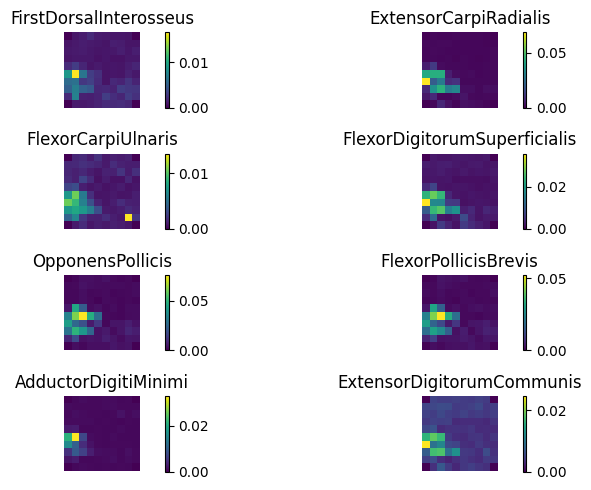

In [14]:
im = np.zeros((10, 10))

n_cols, n_rows = 4, 2

fig, axs = plt.subplots(n_cols, n_rows, figsize=(9, 5))
# Remplissage de chaque carte avec les valeurs de response correspondantes
for i, ax in enumerate(axs.flat):
    im.fill(0)  # Remise à zéro de la carte pour chaque sous-plot
    for j in range(len(ch2xy)):
        x, y = ch2xy[j]
        im[int(x), int(y)] = valid_respMean[i, j]

    image = ax.imshow(im, cmap="viridis", interpolation="nearest")
    ax.set_title("{}".format(emgs[i][0]))
    cbar = fig.colorbar(image, ax=ax)
    ax.axis("off")


plt.tight_layout()
plt.show()

emg  0


100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


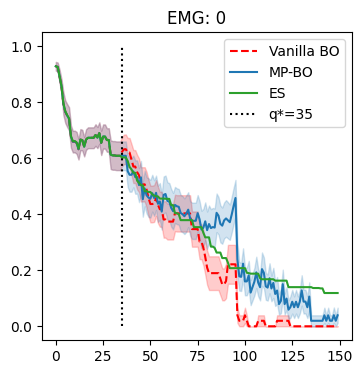

emg  1


100%|██████████| 30/30 [00:24<00:00,  1.25it/s]


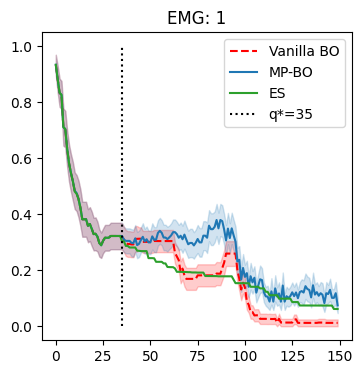

emg  2


100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


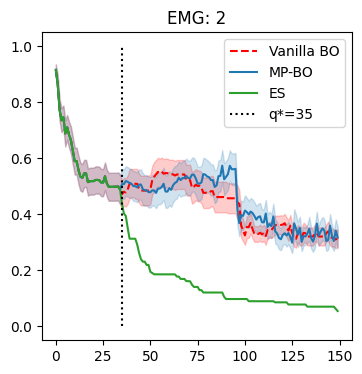

emg  3


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


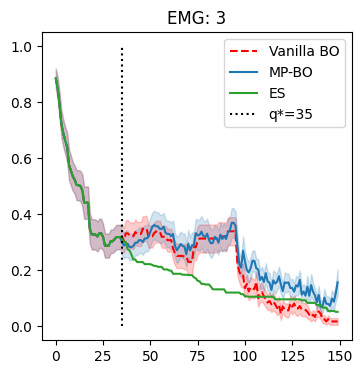

emg  4


100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


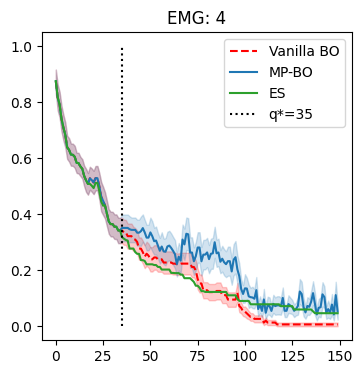

emg  5


100%|██████████| 30/30 [00:21<00:00,  1.36it/s]


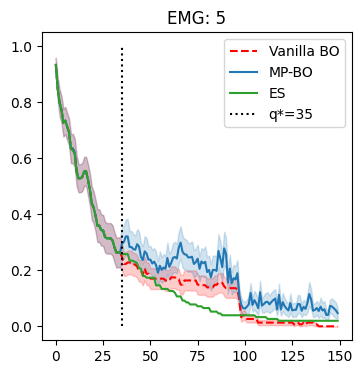

emg  6


100%|██████████| 30/30 [00:24<00:00,  1.25it/s]


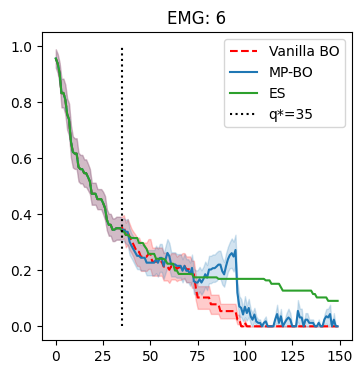

emg  7


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


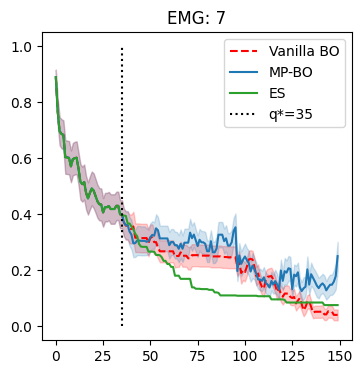

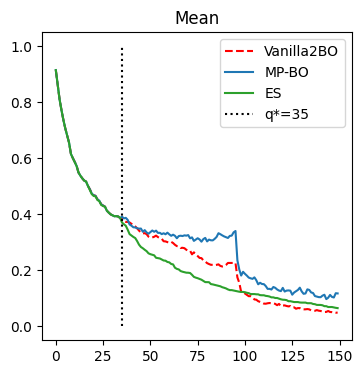

In [15]:
mean_regret_cebus2 = np.zeros((response.shape[1], 150, 3))
q_star = 35


for emg in range(response.shape[1]):
    print("emg ", emg)
    response_emg = response[:, emg, :]
    isvalid_emg = valid[:, emg, :]
    respMean_emg = valid_respMean[emg, :]

    opt = BayesianOptimizer(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )
    es = ExtensiveSearch(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )

    regret_gpbo, baseline = opt.train(
        4,
        initial_points=1,
        repetitions=30,
        iterations=150,
        strategy="Vanilla BO",
    )
    regret_mpbo, _ = opt.train(
        4,
        repetitions=30,
        iterations=150,
        strategy="MP-BO",
        begin_strat=q_star,
        initial_points=q_star,
        follow_baseline=baseline,
    )

    regret_es = es.train(
        4,
        repetitions=30,
        iterations=150,
        initial_points=q_star,
        begin_strat=q_star,
        follow_baseline=baseline,
    )

    mean_regret_cebus2[emg, :, 0] = regret_gpbo.mean(0)
    mean_regret_cebus2[emg, :, 1] = regret_mpbo.mean(0)
    mean_regret_cebus2[emg, :, 2] = regret_es.mean(0)

    plt.figure(figsize=(4, 4))
    plt.plot(regret_gpbo.mean(0), color="red", linestyle="--", label="Vanilla BO")
    plt.fill_between(
        range(150),
        regret_gpbo.mean(0) - regret_gpbo.std(0) / np.sqrt(30),
        regret_gpbo.mean(0) + regret_gpbo.std(0) / np.sqrt(30),
        color="red",
        alpha=0.2,
    )
    plt.plot(regret_mpbo.mean(0), color="tab:blue", label="MP-BO")
    plt.fill_between(
        range(150),
        regret_mpbo.mean(0) - regret_mpbo.std(0) / np.sqrt(30),
        regret_mpbo.mean(0) + regret_mpbo.std(0) / np.sqrt(30),
        color="tab:blue",
        alpha=0.2,
    )
    plt.plot(regret_es.mean(0), color="tab:green", label="ES")
    plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
    plt.legend()
    plt.title(f"EMG: {emg}")
    plt.show()


plt.figure(figsize=(4, 4))
plt.plot(
    mean_regret_cebus2.mean(0)[:, 0], color="red", linestyle="--", label="Vanilla2BO"
)
plt.plot(mean_regret_cebus2.mean(0)[:, 1], color="tab:blue", label="MP-BO")
plt.plot(mean_regret_cebus2.mean(0)[:, 2], color="tab:green", label="ES")

plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
plt.legend()
plt.title("Mean")

np.savez(
    "Cebus2.npz",
    gpbo=mean_regret_cebus2[:, :, 0],
    mpbo=mean_regret_cebus2[:, :, 1],
    extensivesearch=mean_regret_cebus2[:, :, 2],
)

Macaque 1:

In [21]:
data = loadmat("datasets/neurostim/Macaque1_M1_181212.mat")["Macaque1_M1_181212"]
emgs = np.squeeze(data["emgs"][0][0], axis=0)
ch2xy = data["ch2xy"][0][0] - 1

sorted_resp = data["sorted_resp"][0, 0].T
sorted_isvalid = data["sorted_isvalid"][0, 0].T
valid = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))
response = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))

for emg in range(emgs.shape[0]):
    for chan in range(sorted_resp.shape[1]):
        response[:, emg, chan] = np.squeeze(sorted_resp[emg, chan], axis=1)
        valid[:, emg, chan] = np.squeeze(sorted_isvalid[emg, chan], axis=1)


valid_respMean = np.zeros((response.shape[2], emgs.shape[0]))


for chan in range(response.shape[2]):
    for emg in range(emgs.shape[0]):
        valid_idx = list(np.where(valid[:, emg, chan] == 1)[0])
        non_valid_non_detectable_idx = list(np.where(valid[:, emg, chan] == -1)[0])
        all_valid_idx = valid_idx + non_valid_non_detectable_idx
        valid_respMean[chan, emg] = np.mean(response[all_valid_idx, emg, chan])


ch2xy = torch.from_numpy(ch2xy).float()
response = torch.from_numpy(response).float()
valid_respMean = torch.from_numpy(valid_respMean).float().permute(1, 0)
valid = torch.from_numpy(valid).float()

print(ch2xy.shape)
print(response.shape)
print(valid_respMean.shape)
print(valid.shape)

torch.Size([96, 2])
torch.Size([20, 4, 96])
torch.Size([4, 96])
torch.Size([20, 4, 96])


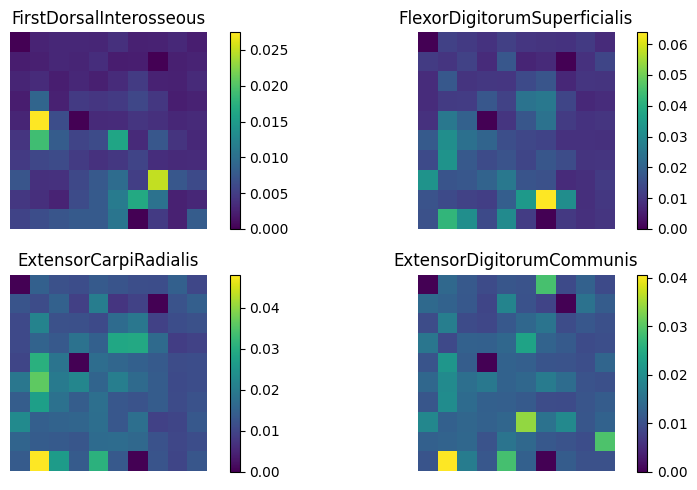

In [22]:
im = np.zeros((10, 10))

n_cols, n_rows = 2, 2

fig, axs = plt.subplots(n_cols, n_rows, figsize=(9, 5))
# Remplissage de chaque carte avec les valeurs de response correspondantes
for i, ax in enumerate(axs.flat):
    im.fill(0)  # Remise à zéro de la carte pour chaque sous-plot
    for j in range(len(ch2xy)):
        x, y = ch2xy[j]
        im[int(x), int(y)] = valid_respMean[i, j]

    image = ax.imshow(im, cmap="viridis", interpolation="nearest")
    ax.set_title("{}".format(emgs[i][0]))
    cbar = fig.colorbar(image, ax=ax)
    ax.axis("off")


plt.tight_layout()
plt.show()

emg  0


100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


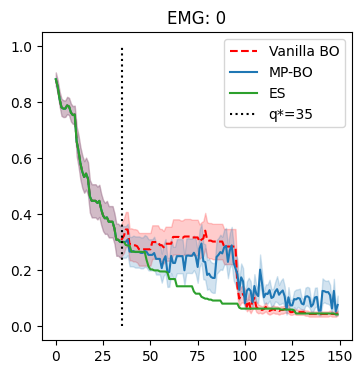

emg  1


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


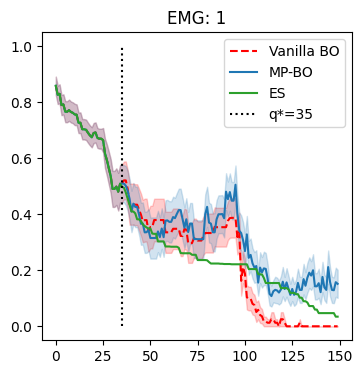

emg  2


100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


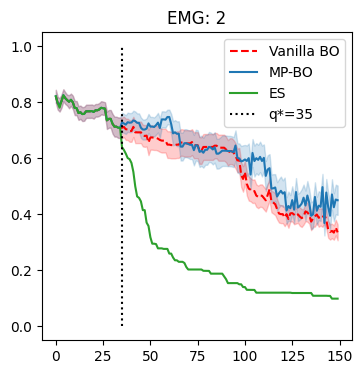

emg  3


100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


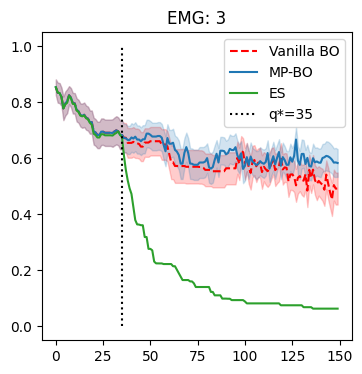

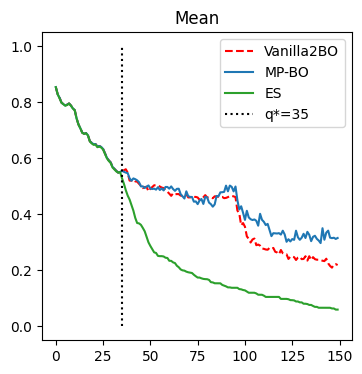

In [23]:
mean_regret_mac1 = np.zeros((response.shape[1], 150, 3))
q_star = 35


for emg in range(response.shape[1]):
    print("emg ", emg)
    response_emg = response[:, emg, :]
    isvalid_emg = valid[:, emg, :]
    respMean_emg = valid_respMean[emg, :]

    opt = BayesianOptimizer(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )
    es = ExtensiveSearch(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )

    regret_gpbo, baseline = opt.train(
        4,
        initial_points=1,
        repetitions=30,
        iterations=150,
        strategy="Vanilla BO",
    )
    regret_mpbo, _ = opt.train(
        4,
        repetitions=30,
        iterations=150,
        strategy="MP-BO",
        begin_strat=q_star,
        initial_points=q_star,
        follow_baseline=baseline,
    )

    regret_es = es.train(
        4,
        repetitions=30,
        iterations=150,
        initial_points=q_star,
        begin_strat=q_star,
        follow_baseline=baseline,
    )

    mean_regret_mac1[emg, :, 0] = regret_gpbo.mean(0)
    mean_regret_mac1[emg, :, 1] = regret_mpbo.mean(0)
    mean_regret_mac1[emg, :, 2] = regret_es.mean(0)

    plt.figure(figsize=(4, 4))
    plt.plot(regret_gpbo.mean(0), color="red", linestyle="--", label="Vanilla BO")
    plt.fill_between(
        range(150),
        regret_gpbo.mean(0) - regret_gpbo.std(0) / np.sqrt(30),
        regret_gpbo.mean(0) + regret_gpbo.std(0) / np.sqrt(30),
        color="red",
        alpha=0.2,
    )
    plt.plot(regret_mpbo.mean(0), color="tab:blue", label="MP-BO")
    plt.fill_between(
        range(150),
        regret_mpbo.mean(0) - regret_mpbo.std(0) / np.sqrt(30),
        regret_mpbo.mean(0) + regret_mpbo.std(0) / np.sqrt(30),
        color="tab:blue",
        alpha=0.2,
    )
    plt.plot(regret_es.mean(0), color="tab:green", label="ES")
    plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
    plt.legend()
    plt.title(f"EMG: {emg}")
    plt.show()


plt.figure(figsize=(4, 4))
plt.plot(
    mean_regret_mac1.mean(0)[:, 0], color="red", linestyle="--", label="Vanilla2BO"
)
plt.plot(mean_regret_mac1.mean(0)[:, 1], color="tab:blue", label="MP-BO")
plt.plot(mean_regret_mac1.mean(0)[:, 2], color="tab:green", label="ES")

plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
plt.legend()
plt.title("Mean")

np.savez(
    "Mac1.npz",
    gpbo=mean_regret_mac1[:, :, 0],
    mpbo=mean_regret_mac1[:, :, 1],
    extensivesearch=mean_regret_mac1[:, :, 2],
)

Macaque 2:

In [44]:
data = loadmat("datasets/neurostim/Macaque2_M1_190527.mat")["Macaque2_M1_190527"]
emgs = np.squeeze(data["emgs"][0][0], axis=0)
ch2xy = data["ch2xy"][0][0] - 1


sorted_resp = data["sorted_resp"][0, 0].T
sorted_isvalid = data["sorted_isvalid"][0, 0].T
valid = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))
response = np.zeros((sorted_resp[0, 0].shape[0], emgs.shape[0], sorted_resp.shape[1]))

for emg in range(emgs.shape[0]):
    for chan in range(sorted_resp.shape[1]):
        response[:, emg, chan] = np.squeeze(sorted_resp[emg, chan], axis=1)
        valid[:, emg, chan] = np.squeeze(sorted_isvalid[emg, chan], axis=1)


valid_respMean = np.zeros((emgs.shape[0], response.shape[2]))


for chan in range(response.shape[2]):
    for emg in range(emgs.shape[0]):
        valid_idx = list(np.where(valid[:, emg, chan] == 1)[0])
        non_valid_non_detectable_idx = list(np.where(valid[:, emg, chan] == -1)[0])
        all_valid_idx = valid_idx + non_valid_non_detectable_idx
        valid_respMean[emg, chan] = np.mean(response[all_valid_idx, emg, chan])

# print(data["map"][0, 0])
# print(valid_respMean[:, 0])

map = data["map"][0, 0] - 1
ch2xy = torch.from_numpy(ch2xy).long()
response = torch.from_numpy(response).float()
valid_respMean = torch.from_numpy(valid_respMean).float()
valid = torch.from_numpy(valid).float()

print(ch2xy[0])
i = map[*ch2xy[0]]
print(response[0, 0, i])
print(response[0, 0, 0])

print(ch2xy.shape)
print(response.shape)
print(valid_respMean.shape)
print(valid.shape)

tensor([9, 8])
8
tensor(0.0232)
tensor(0.0240)
torch.Size([96, 2])
torch.Size([10, 4, 96])
torch.Size([4, 96])
torch.Size([10, 4, 96])


4


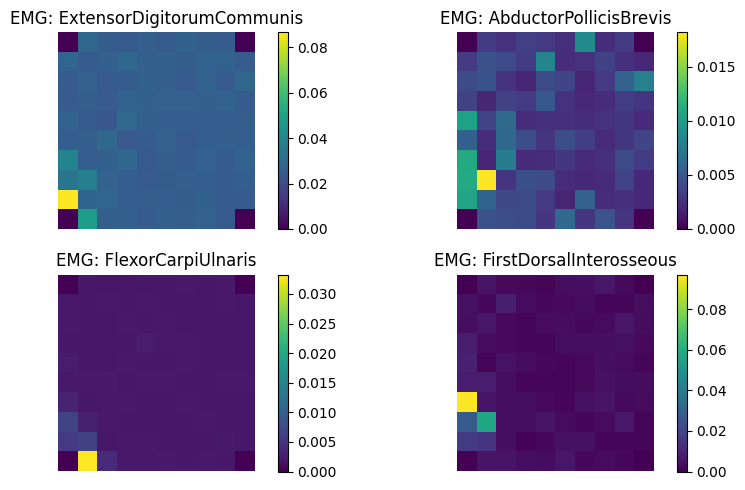

In [38]:
im = np.zeros((10, 10))

print(len(emgs))
n_cols, n_rows = 2, 2

fig, axs = plt.subplots(n_cols, n_rows, figsize=(9, 5))
# Remplissage de chaque carte avec les valeurs de response correspondantes
for i, ax in enumerate(axs.flat):
    im.fill(0)  # Remise à zéro de la carte pour chaque sous-plot
    for j in range(len(ch2xy)):
        x, y = ch2xy[j]
        im[int(x), int(y)] = valid_respMean[i, map[int(x), int(y)]]

    image = ax.imshow(im, cmap="viridis", interpolation="nearest")
    ax.set_title("EMG: {}".format(emgs[i][0]))
    cbar = fig.colorbar(image, ax=ax)
    ax.axis("off")


plt.tight_layout()
plt.show()

multiple


100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


multiple


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


multiple


100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


multiple


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


multiple


100%|██████████| 30/30 [01:16<00:00,  2.55s/it]


multiple


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


multiple


100%|██████████| 30/30 [01:15<00:00,  2.53s/it]


multiple


100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


Text(0.5, 1.0, 'Mean')

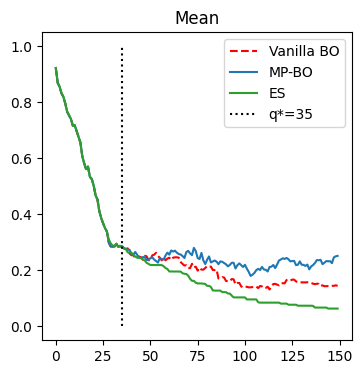

In [17]:
mean_regret_mac2 = np.zeros((response.shape[1], 150, 3))
q_star = 35


for emg in range(response.shape[1]):
    print("emg ", emg)
    response_emg = response[:, emg, :]
    isvalid_emg = valid[:, emg, :]
    respMean_emg = valid_respMean[:, emg]

    opt = BayesianOptimizer(
        ch2xy, response_emg, isvalid=isvalid_emg, respMean_valid=respMean_emg, map=map
    )
    es = ExtensiveSearch(ch2xy, response_emg)

    regret_gpbo, baseline = opt.train(
        4,
        initial_points=1,
        repetitions=30,
        iterations=150,
        strategy="Vanilla BO",
    )
    regret_mpbo, _ = opt.train(
        4,
        repetitions=30,
        iterations=150,
        strategy="MP-BO",
        begin_strat=q_star,
        initial_points=q_star,
        follow_baseline=baseline,
    )

    regret_es = es.train(
        4,
        repetitions=30,
        iterations=150,
        initial_points=q_star,
        begin_strat=q_star,
        follow_baseline=baseline,
    )

    mean_regret_mac2[emg, :, 0] = regret_gpbo.mean(0)
    mean_regret_mac2[emg, :, 1] = regret_mpbo.mean(0)
    mean_regret_mac2[emg, :, 2] = regret_es.mean(0)

    plt.figure(figsize=(4, 4))
    plt.plot(regret_gpbo.mean(0), color="red", linestyle="--", label="Vanilla BO")
    plt.fill_between(
        range(150),
        regret_gpbo.mean(0) - regret_gpbo.std(0) / np.sqrt(30),
        regret_gpbo.mean(0) + regret_gpbo.std(0) / np.sqrt(30),
        color="red",
        alpha=0.2,
    )
    plt.plot(regret_mpbo.mean(0), color="tab:blue", label="MP-BO")
    plt.fill_between(
        range(150),
        regret_mpbo.mean(0) - regret_mpbo.std(0) / np.sqrt(30),
        regret_mpbo.mean(0) + regret_mpbo.std(0) / np.sqrt(30),
        color="tab:blue",
        alpha=0.2,
    )
    plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
    plt.legend()
    plt.title(f"EMG: {emg}")
    plt.show()


plt.figure(figsize=(4, 4))
plt.plot(
    mean_regret_mac2.mean(0)[:, 0], color="red", linestyle="--", label="Vanilla BO"
)

plt.plot(mean_regret_cebus2.mean(0)[:, 1], color="tab:blue", label="MP-BO")
plt.plot(mean_regret_cebus2.mean(0)[:, 2], color="tab:green", label="ES")

plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
plt.legend()
plt.title("Mean")

In [ ]:
# Display mean of all datasets
plt.figure(figsize=(4, 4))
plt.plot(
    np.concatenate(
        [
            mean_regret_cebus1.mean(0)[:, 0],
            mean_regret_cebus2.mean(0)[:, 0],
            mean_regret_mac1.mean(0)[:, 0],
            mean_regret_mac2.mean(0)[:, 0],
        ]
    ),
    color="red",
    linestyle="--",
    label="Vanilla BO",
)

plt.plot(
    np.concatenate(
        [
            mean_regret_cebus1.mean(0)[:, 1],
            mean_regret_cebus2.mean(0)[:, 1],
            mean_regret_mac1.mean(0)[:, 1],
            mean_regret_mac2.mean(0)[:, 1],
        ]
    ),
    color="tab:blue",
    label="MP-BO",
)

plt.plot(
    np.concatenate(
        [
            mean_regret_cebus1.mean(0)[:, 2],
            mean_regret_cebus2.mean(0)[:, 2],
            mean_regret_mac1.mean(0)[:, 2],
            mean_regret_mac2.mean(0)[:, 2],
        ]
    ),
    color="tab:green",
    label="ES",
)